# Wilcoxonの符号順位検定の頑健性チェック

* 黒木玄
* 作成: 2025-12-06
* 文脈: https://x.com/genkuroki/status/1996556375800025396
* Colab: https://colab.research.google.com/github/genkuroki/public/blob/main/0055/Wilcoxon's%20signed%20rank%20test.ipynb

In [1]:
# Google Colabと自分のパソコンの両方で使えるようにするための工夫

haskey(ENV, "COLAB_GPU") && (ENV["JULIA_PKG_PRECOMPILE_AUTO"] = "0")
using Pkg

"""すでにPkg.add済みのパッケージのリスト"""
_packages_added = [sort!(readdir(Sys.STDLIB));
    sort!([info.name for (uuid, info) in Pkg.dependencies() if info.is_direct_dep])]

"""_packages_added内にないパッケージをPkg.addする"""
add_pkg_if_not_added_yet(pkg) = if isnothing(Base.find_package(pkg))
    println(stderr, "# $(pkg).jl is not added yet, so let's add it.")
    Pkg.add(pkg)
end
9
"""expr::Exprからusing内の`.`を含まないモジュール名を抽出"""
function find_using_pkgs(expr::Expr)
    pkgs = String[]
    function traverse(expr::Expr)
        if expr.head == :using
            for arg in expr.args
                if arg.head == :. && length(arg.args) == 1
                    push!(pkgs, string(arg.args[1]))
                elseif arg.head == :(:) && length(arg.args[1].args) == 1
                    push!(pkgs, string(arg.args[1].args[1]))
                end
            end
        else
            for arg in expr.args arg isa Expr && traverse(arg) end
        end
    end
    traverse(expr)
    pkgs
end

"""必要そうなPkg.addを追加するマクロ"""
macro autoadd(expr)
    pkgs = find_using_pkgs(expr)
    :(add_pkg_if_not_added_yet.($(pkgs)); $expr)
end

@autoadd

In [2]:
using Random

_nthreads() = Threads.nthreads(:interactive) + Threads.nthreads(:default)

using Random
using Statistics

@autoadd begin
using Distributions
using HypothesisTests
using Plots
end

default(fmt=:png, legend=false, size=(400, 400), titlefontsize=9, tickfontsize=7)

@eval Distributions begin
function logpdf(d::InverseGamma, x::Real)
    x ≤ 0 && return -Inf
    (α, θ) = params(d)
    α * log(θ) - loggamma(α) - (α + 1) * log(x) - θ / x
end
end

distname(dist) = replace(string(dist), r"{[^}]*}"=>"", r".="=>"")
distname(dist::InverseGamma) = "InverseGamma$(params(dist))"
function distname(dist::MixtureModel; r=x->round(x; sigdigits=4))
    n = ncomponents(dist)
    c = components(dist)
    p = probs(dist)
    "$(r(p[1]))" * distname(c[1]) * prod("+$(r(p[k]))" * distname(c[k]) for k in 2:n)
end
distname(dist::Normal) = "N$(params(dist))"

_ecdf(A, x) = count(≤(x), A) / length(A)

function median_x1_plus_x2_monte_carlo(dist::ContinuousUnivariateDistribution; niters=10^8, naves=1)
    s = 0.0
    X1_plus_X2 = zeros(niters)
    for j in 1:naves
        Threads.@threads for i in 1:niters
            X1_plus_X2[i] = rand(dist) + rand(dist)
        end
        s += median!(X1_plus_X2)
    end
    s / naves
end

function prob_x1_plus_x2_gt_zero_monte_carlo(dist; niters=10^8, naves=1)
    s = 0.0
    X1_plus_X2 = zeros(niters)
    for j in 1:naves
        Threads.@threads for i in 1:niters
            X1_plus_X2[i] = rand(dist) + rand(dist)
        end
        s += count(>(0), X1_plus_X2) / length(X1_plus_X2)
    end
    s / naves
end

prob_x1_plus_x2_gt_zero_monte_carlo (generic function with 1 method)

In [3]:
@show dist = Gamma(0.03, 10000)
@time m1 = median_x1_plus_x2_monte_carlo(dist)
@time m2 = median_x1_plus_x2_monte_carlo(dist)
@time m3 = median_x1_plus_x2_monte_carlo(dist)
@show m1 m2 m3
m = m1
@time p1 = prob_x1_plus_x2_gt_zero_monte_carlo(dist - m/2)
@time p2 = prob_x1_plus_x2_gt_zero_monte_carlo(dist - m/2)
@time p3 = prob_x1_plus_x2_gt_zero_monte_carlo(dist - m/2)
@show p1 p2 p3;

dist = Gamma(0.03, 10000) = Gamma{Float64}(α=0.03, θ=10000.0)
  5.728238 seconds (411.84 M allocations: 13.231 GiB, 29.33% gc time, 13.49% compilation time)
  3.796182 seconds (400.00 M allocations: 12.676 GiB, 27.76% gc time)
  3.796171 seconds (400.00 M allocations: 12.676 GiB, 28.42% gc time)
m1 = 0.05652624289423237
m2 = 0.056566550072668115
m3 = 0.056678485609019794
  3.841165 seconds (400.37 M allocations: 12.683 GiB, 30.91% gc time, 10.23% compilation time)
  3.742803 seconds (400.00 M allocations: 12.666 GiB, 30.28% gc time)
  3.695693 seconds (400.00 M allocations: 12.666 GiB, 31.81% gc time)
p1 = 0.50009781
p2 = 0.50008946
p3 = 0.50007847


In [4]:
function sim_signed_rank_test(dist::ContinuousUnivariateDistribution, n;
        niters = 10^5,
        distshift = median_x1_plus_x2_monte_carlo(dist) / 2
    )
    dist_null = dist - distshift
    nth = _nthreads()
    Xtmp = [zeros(n) for _ in 1:nth]
    pval = zeros(niters)
    Threads.@threads :static for i in 1:niters
        tid = Threads.threadid()
        X = rand!(dist_null, Xtmp[tid])
        pval[i] = pvalue(SignedRankTest(X))
    end
    pval
end

function plot_sim_signed_rank_test(dist::ContinuousUnivariateDistribution, n;
        niters = 10^5,
        str_dist = distname(dist), 
        distshift = median_x1_plus_x2_monte_carlo(dist) / 2,
        dist_null = dist - distshift,
        μ = mean(dist_null),
        σ = std(dist_null),
        xmin = μ - 5σ,
        xmax = μ + 5σ,
        xs = range(xmin, xmax, 2000),
        ymax = min(10, maximum(pdf(dist_null, x) for x in xs)),
        amax = 0.1,
        r = x -> round(x; digits=4),
        rsd = x -> round(x; sigdigits=4),
    )
    str_dist_null = str_dist * (distshift + 1 ≈ 1 ? "" : (distshift > 0 ? " - " : " + ") * "$(rsd(abs(distshift)))")
    
    println("Xᵢ ~ ", str_dist_null) 
    println("P(X₁ + X₂ > 0) = ", r(prob_x1_plus_x2_gt_zero_monte_carlo(dist_null)))
    println("P(X₁ > 0) = ", r(ccdf(dist_null, 0)))
    println("median(X₁)) = ", rsd(median(dist_null)))
    println("mean(X₁)) = ", rsd(mean(dist_null)))
    
    pval = sim_signed_rank_test(dist, n; niters, distshift)
    P = plot(xs, x -> pdf(dist_null, x))
    plot!(ylim=(-0.05ymax, 1.03ymax))
    title!("$str_dist_null,  n=$n")
    Q = plot(α -> _ecdf(pval, α), 0.0, amax)
    plot!(identity; ls=:dot, c=:black, alpha=0.5, lw=0.8)
    xtick = ytick = amax > 0.14 ? (0:0.1:1) : (0:0.01:1)
    plot!(; xtick, ytick)
    plot!(xguide="α", yguide="probability of P-value ≤ α")
    plot!(P, Q; size=(400, 560), layout=@layout[a{0.3h}; b])
end

plot_sim_signed_rank_test (generic function with 1 method)

Xᵢ ~ N(0.0, 1.0) - 8.226e-5
P(X₁ + X₂ > 0) = 0.4999
P(X₁ > 0) = 0.5
median(X₁)) = -8.226e-5
mean(X₁)) = -8.226e-5


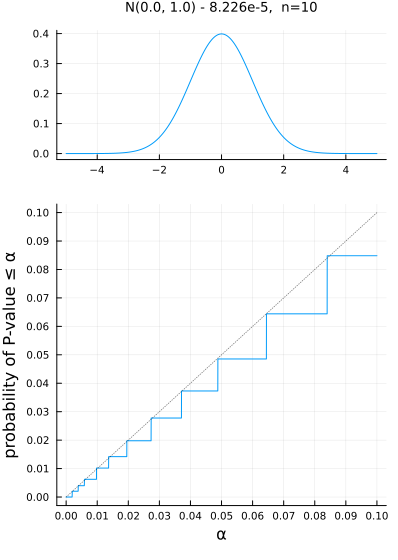

In [5]:
plot_sim_signed_rank_test(Normal(), 10)

Xᵢ ~ InverseGamma(2.01, 1.0) - 0.6924
P(X₁ + X₂ > 0) = 0.5
P(X₁ > 0) = 0.4202
median(X₁)) = -0.1001
mean(X₁)) = 0.2977


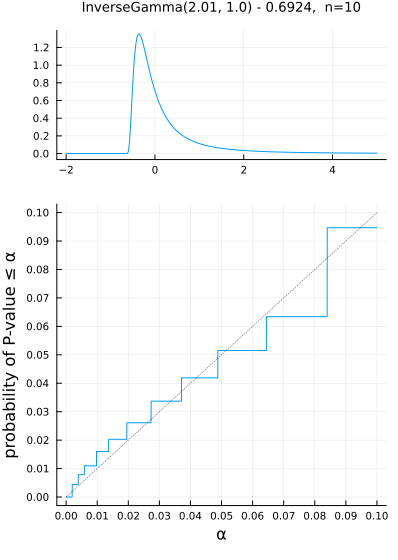

In [6]:
plot_sim_signed_rank_test(InverseGamma(2.01), 10; xmin=-2, xmax=5)

Xᵢ ~ LogNormal(0.0, 1.0) - 1.222
P(X₁ + X₂ > 0) = 0.5
P(X₁ > 0) = 0.4207
median(X₁)) = -0.2216
mean(X₁)) = 0.4272


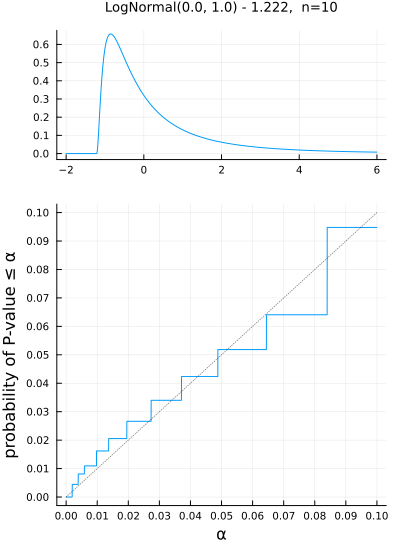

In [7]:
plot_sim_signed_rank_test(LogNormal(), 10; xmin=-2, xmax=6)

Xᵢ ~ Exponential(1.0) - 0.8392
P(X₁ + X₂ > 0) = 0.4999
P(X₁ > 0) = 0.432
median(X₁)) = -0.1461
mean(X₁)) = 0.1608


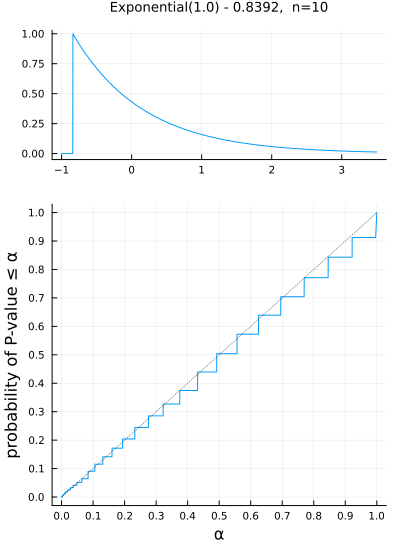

In [8]:
plot_sim_signed_rank_test(Exponential(), 10; xmin=-1, xmax=3.5, amax=1)

Xᵢ ~ Exponential(1.0) - 0.8392
P(X₁ + X₂ > 0) = 0.4999
P(X₁ > 0) = 0.4321
median(X₁)) = -0.146
mean(X₁)) = 0.1608


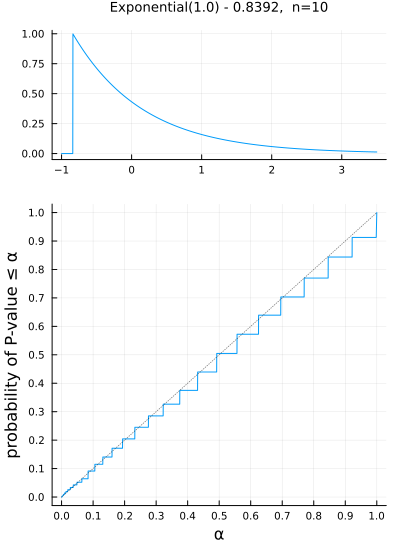

In [9]:
plot_sim_signed_rank_test(Exponential(), 10; xmin=-1, xmax=3.5, amax=1)

Xᵢ ~ Exponential(1.0) - 0.8392
P(X₁ + X₂ > 0) = 0.5
P(X₁ > 0) = 0.432
median(X₁)) = -0.1461
mean(X₁)) = 0.1608


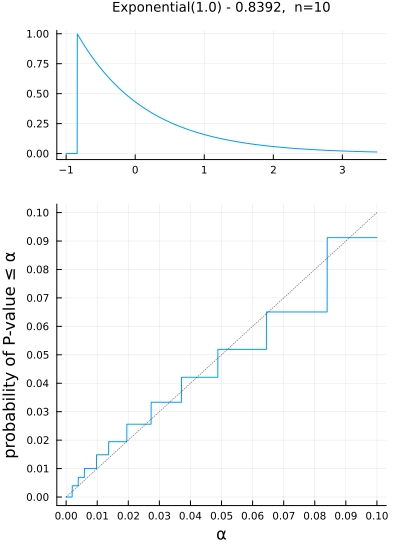

In [10]:
plot_sim_signed_rank_test(Exponential(), 10; xmin=-1, xmax=3.5)

Xᵢ ~ Exponential(1.0) - 0.8392
P(X₁ + X₂ > 0) = 0.4999
P(X₁ > 0) = 0.4321
median(X₁)) = -0.146
mean(X₁)) = 0.1608


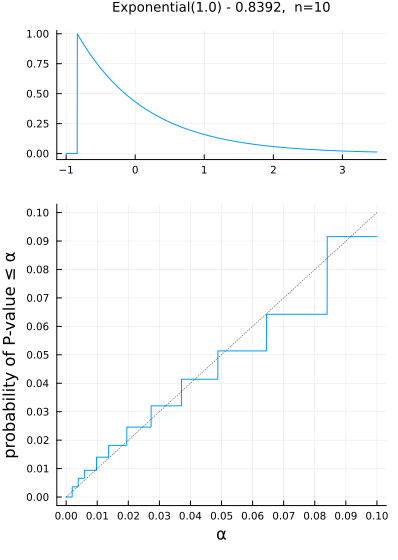

In [11]:
plot_sim_signed_rank_test(Exponential(), 10; xmin=-1, xmax=3.5)

Xᵢ ~ Gamma(0.1, 10.0) - 0.1037
P(X₁ + X₂ > 0) = 0.5
P(X₁ > 0) = 0.335
median(X₁)) = -0.0978
mean(X₁)) = 0.8963


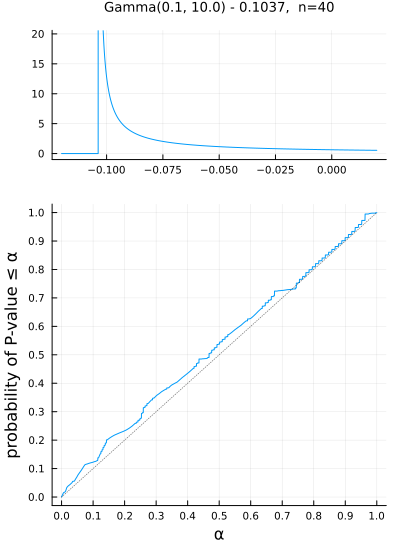

In [12]:
plot_sim_signed_rank_test(Gamma(0.1, 10), 40; xmin=-0.12, xmax=0.02, ymax=20, amax=1)

Xᵢ ~ Gamma(0.1, 10.0) - 0.1038
P(X₁ + X₂ > 0) = 0.5
P(X₁ > 0) = 0.3349
median(X₁)) = -0.09787
mean(X₁)) = 0.8962


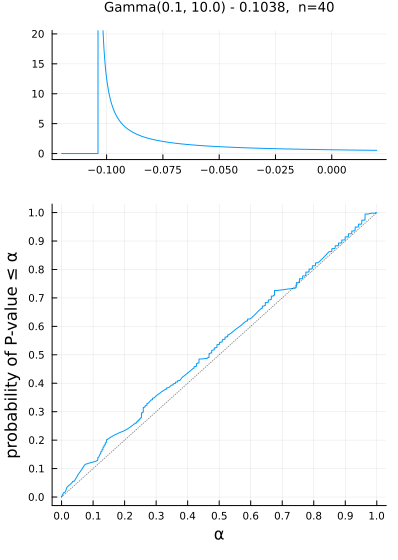

In [13]:
plot_sim_signed_rank_test(Gamma(0.1, 10), 40; xmin=-0.12, xmax=0.02, ymax=20, amax=1)

Xᵢ ~ Gamma(0.1, 10.0) - 0.1037
P(X₁ + X₂ > 0) = 0.5
P(X₁ > 0) = 0.335
median(X₁)) = -0.09778
mean(X₁)) = 0.8963


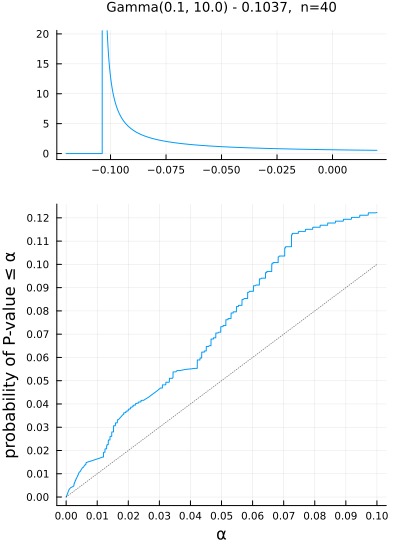

In [14]:
plot_sim_signed_rank_test(Gamma(0.1, 10), 40; xmin=-0.12, xmax=0.02, ymax=20)

Xᵢ ~ Gamma(0.1, 10.0) - 0.1037
P(X₁ + X₂ > 0) = 0.5
P(X₁ > 0) = 0.335
median(X₁)) = -0.09778
mean(X₁)) = 0.8963


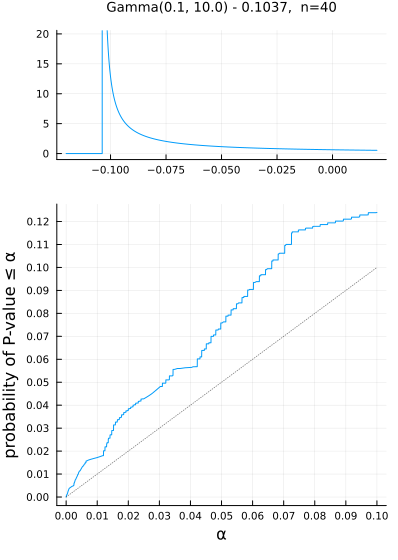

In [15]:
plot_sim_signed_rank_test(Gamma(0.1, 10), 40; xmin=-0.12, xmax=0.02, ymax=20)

Xᵢ ~ Gamma(0.05, 20.0) - 0.005931
P(X₁ + X₂ > 0) = 0.5
P(X₁ > 0) = 0.3157
median(X₁)) = -0.005919
mean(X₁)) = 0.9941


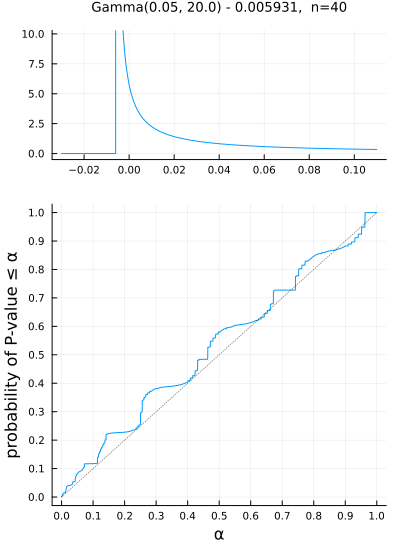

In [16]:
plot_sim_signed_rank_test(Gamma(0.05, 20), 40; xmin=-0.03, xmax=0.11, amax=1)

Xᵢ ~ Gamma(0.05, 20.0) - 0.005947
P(X₁ + X₂ > 0) = 0.4999
P(X₁ > 0) = 0.3156
median(X₁)) = -0.005935
mean(X₁)) = 0.9941


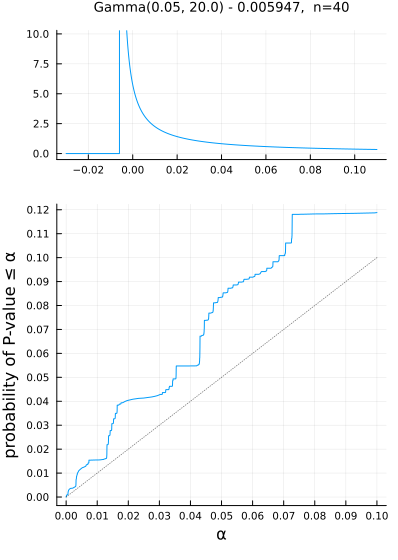

In [17]:
plot_sim_signed_rank_test(Gamma(0.05, 20), 40; xmin=-0.03, xmax=0.11)

Xᵢ ~ Gamma(0.05, 20.0) - 0.005933
P(X₁ + X₂ > 0) = 0.5
P(X₁ > 0) = 0.3157
median(X₁)) = -0.005922
mean(X₁)) = 0.9941


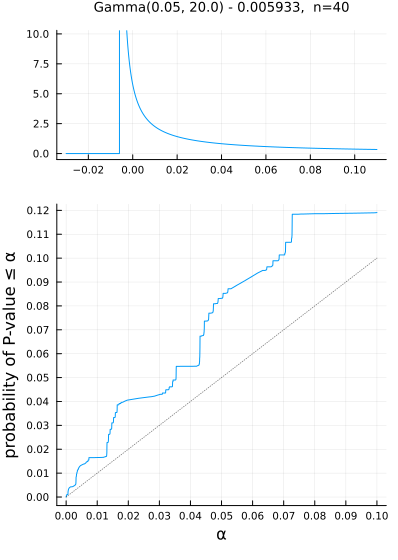

In [18]:
plot_sim_signed_rank_test(Gamma(0.05, 20), 40; xmin=-0.03, xmax=0.11)

Xᵢ ~ 0.491N(0.0, 1.0)+0.509N(2.0, 2.0) - 0.8819
P(X₁ + X₂ > 0) = 0.5
P(X₁ > 0) = 0.4551
median(X₁)) = -0.1965
mean(X₁)) = 0.1361


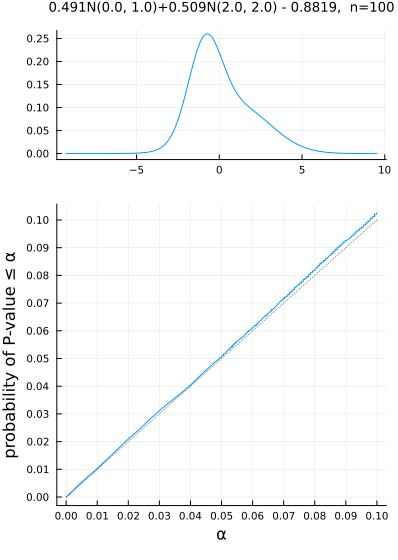

In [19]:
mixnormal = MixtureModel([Normal(), Normal(2, 2)], [0.491, 1-0.491])
plot_sim_signed_rank_test(mixnormal, 100)

Xᵢ ~ 0.491N(0.0, 1.0)+0.509N(2.0, 2.0) - 0.6854
P(X₁ + X₂ > 0) = 0.5588
P(X₁ > 0) = 0.5
median(X₁)) = 0.0
mean(X₁)) = 0.3326


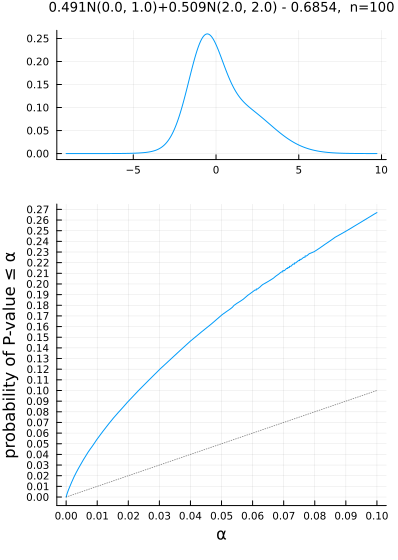

In [20]:
plot_sim_signed_rank_test(mixnormal, 100; distshift=median(mixnormal))

Xᵢ ~ 0.491N(0.0, 1.0)+0.509N(2.0, 2.0) - 0.6854
P(X₁ + X₂ > 0) = 0.5587
P(X₁ > 0) = 0.5
median(X₁)) = 0.0
mean(X₁)) = 0.3326


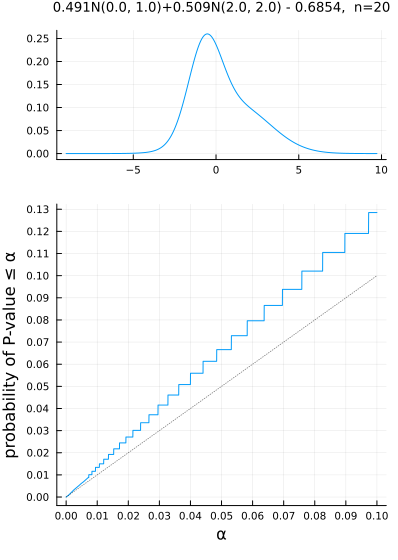

In [21]:
plot_sim_signed_rank_test(mixnormal, 20; distshift=median(mixnormal))

Xᵢ ~ 0.491N(0.0, 1.0)+0.509N(2.0, 2.0) - 0.6854
P(X₁ + X₂ > 0) = 0.5588
P(X₁ > 0) = 0.5
median(X₁)) = 0.0
mean(X₁)) = 0.3326


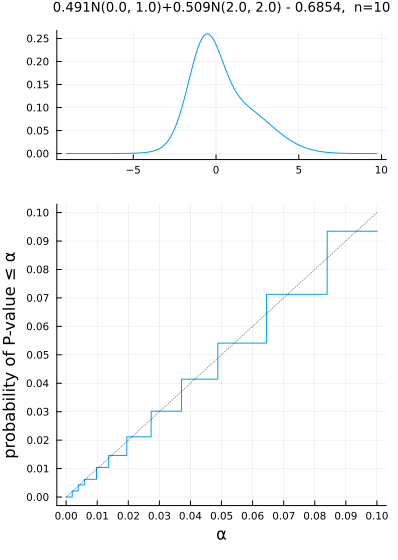

In [22]:
plot_sim_signed_rank_test(mixnormal, 10; distshift=median(mixnormal))

* https://x.com/Iguchi_Y/status/1997361599766790314
* https://etheses.bham.ac.uk/id/eprint/4607/1/Voraprateep13MRes.pdf

In [23]:
ENV["COLUMNS"] = 200

function table_sim_signed_rank_test(dist, ns, deltas; α = 0.05, niters = 10^5)
    tbl = zeros(length(deltas), length(ns))
    for i in 1:size(deltas, 1)
        for j in 1:size(ns, 1)
            pval = sim_signed_rank_test(dist+deltas[i], ns[j]; niters, distshift=0.0)
            tbl[i, j] = round(100_ecdf(pval, α); digits=2)
        end
    end
    Any[
        "δ\n"  ns'
        deltas tbl
    ]
end

table_sim_signed_rank_test (generic function with 1 method)

In [24]:
alphas = [0.0, 0.101, 0.175, 0.256, 0.382, 0.491]
etas = 0:0.1:0.5
ns = [10, 20, 30, 40, 50, 60, 100, 200, 500]
deltas = [0.0, 0.01, 0.05, 0.10, 0.15, 0.20, 0.25]
r = x -> round(x; digits=4)

for (alpha, eta) in zip(alphas, etas)
@time begin
    println()
    @show eta
    @show alpha
    mixnormal = MixtureModel([Normal(), Normal(2, 2)], [alpha, 1-alpha])
    dist = mixnormal - median(mixnormal)
    @show distname(mixnormal)
    @show r(median(mixnormal))
    @show r(median_x1_plus_x2_monte_carlo(mixnormal) / 2)
    @show r(median(dist))
    @show r(ccdf(dist, 0.0))
    @show r(prob_x1_plus_x2_gt_zero_monte_carlo(dist))
    table_sim_signed_rank_test(dist, ns, deltas) |> display
    println()
end
end


eta = 0.0
alpha = 0.0
distname(mixnormal) = "0.0N(0.0, 1.0)+1.0N(2.0, 2.0)"
r(median(mixnormal)) = 2.0
r(median_x1_plus_x2_monte_carlo(mixnormal) / 2) = 2.0
r(median(dist)) = 0.0
r(ccdf(dist, 0.0)) = 0.5
r(prob_x1_plus_x2_gt_zero_monte_carlo(dist)) = 0.5


8×10 Matrix{Any}:
  "δ\n"  10     20     30     40     50     60     100     200     500
 0.0      4.86   4.78   4.96   4.91   4.84   4.91    4.98    5.08    4.88
 0.01     4.83   4.92   5.02   4.94   4.94   4.8     4.93    5.03    5.06
 0.05     4.93   4.86   5.2    5.14   5.27   5.28    5.6     6.28    8.53
 0.1      5.1    5.28   5.81   6.08   6.2    6.48    7.54   10.38   19.07
 0.15     5.33   6.0    6.7    7.32   7.87   8.45   11.11   17.81   37.42
 0.2      5.74   6.82   8.06   9.33  10.39  11.45   15.96   27.92   58.58
 0.25     6.15   7.8    9.95  11.6   13.31  15.15   22.69   40.86   77.9


 19.633851 seconds (153.14 M allocations: 49.781 GiB, 25.85% gc time, 6.05% compilation time: 1% of which was recompilation)

eta = 0.1
alpha = 0.101
distname(mixnormal) = "0.101N(0.0, 1.0)+0.899N(2.0, 2.0)"
r(median(mixnormal)) = 1.7407
r(median_x1_plus_x2_monte_carlo(mixnormal) / 2) = 1.7733
r(median(dist)) = 0.0
r(ccdf(dist, 0.0)) = 0.5
r(prob_x1_plus_x2_gt_zero_monte_carlo(dist)) = 0.5091


8×10 Matrix{Any}:
  "δ\n"  10     20     30     40     50     60     100     200     500
 0.0      4.84   4.96   5.08   4.93   5.17   5.09    5.14    5.53    6.39
 0.01     4.91   4.97   5.19   5.15   5.18   5.28    5.39    5.93    7.5
 0.05     5.07   5.14   5.49   5.68   5.81   5.78    6.79    8.69   14.46
 0.1      5.09   5.5    6.26   6.81   7.11   7.51    9.54   14.31   29.63
 0.15     5.68   6.4    7.3    8.23   9.1    9.92   13.7    23.14   49.77
 0.2      5.92   7.26   9.16  10.22  11.74  13.46   19.4    35.06   70.05
 0.25     6.41   8.59  11.26  13.24  15.37  17.73   26.73   47.88   85.92


 18.780261 seconds (147.69 M allocations: 49.453 GiB, 27.26% gc time)

eta = 0.2
alpha = 0.175
distname(mixnormal) = "0.175N(0.0, 1.0)+0.825N(2.0, 2.0)"
r(median(mixnormal)) = 1.5309
r(median_x1_plus_x2_monte_carlo(mixnormal) / 2) = 1.6066
r(median(dist)) = 0.0
r(ccdf(dist, 0.0)) = 0.5
r(prob_x1_plus_x2_gt_zero_monte_carlo(dist)) = 0.5209


8×10 Matrix{Any}:
  "δ\n"  10     20     30     40     50     60     100     200     500
 0.0      4.87   4.87   5.4    5.49   5.63   5.68    6.33    7.86   12.59
 0.01     5.0    4.89   5.39   5.64   5.87   6.0     6.68    8.92   14.9
 0.05     5.08   5.41   5.98   6.49   6.81   7.27    8.94   13.37   26.93
 0.1      5.4    6.18   7.1    7.94   8.78   9.6    13.1    21.72   46.83
 0.15     5.68   7.16   8.67  10.05  11.44  12.82   18.51   32.98   67.24
 0.2      6.26   8.19  10.37  12.53  14.92  16.83   25.62   45.87   83.81
 0.25     6.88   9.63  13.0   15.87  18.64  21.8    33.68   59.29   93.72


 18.832327 seconds (147.67 M allocations: 49.382 GiB, 27.28% gc time)

eta = 0.3
alpha = 0.256
distname(mixnormal) = "0.256N(0.0, 1.0)+0.744N(2.0, 2.0)"
r(median(mixnormal)) = 1.2923
r(median_x1_plus_x2_monte_carlo(mixnormal) / 2) = 1.4237
r(median(dist)) = 0.0
r(ccdf(dist, 0.0)) = 0.5
r(prob_x1_plus_x2_gt_zero_monte_carlo(dist)) = 0.5362


8×10 Matrix{Any}:
  "δ\n"  10     20     30     40     50     60     100     200     500
 0.0      5.13   5.53   6.11   6.54   7.01   7.42    9.19   14.22   28.9
 0.01     5.19   5.56   6.29   6.94   7.48   7.84    9.97   15.9    32.47
 0.05     5.35   6.12   7.07   8.4    9.06   9.79   13.49   22.98   49.07
 0.1      5.77   7.02   8.74  10.19  11.66  13.23   19.26   34.3    69.84
 0.15     6.18   8.3   10.62  13.07  15.2   17.45   26.51   47.54   85.62
 0.2      6.65   9.56  13.09  16.23  19.44  22.29   34.84   61.07   94.37
 0.25     7.44  11.38  15.79  20.32  24.25  28.15   43.94   73.18   98.42


 19.165189 seconds (147.67 M allocations: 49.292 GiB, 27.57% gc time)

eta = 0.4
alpha = 0.382
distname(mixnormal) = "0.382N(0.0, 1.0)+0.618N(2.0, 2.0)"
r(median(mixnormal)) = 0.9406
r(median_x1_plus_x2_monte_carlo(mixnormal) / 2) = 1.135
r(median(dist)) = 0.0
r(ccdf(dist, 0.0)) = 0.5
r(prob_x1_plus_x2_gt_zero_monte_carlo(dist)) = 0.5547


8×10 Matrix{Any}:
  "δ\n"  10     20     30     40     50     60     100     200     500
 0.0      5.41   6.42   7.6    8.77   9.77  10.99   15.41   26.67   56.6
 0.01     5.27   6.64   8.1    9.0   10.25  11.33   16.4    29.19   60.6
 0.05     5.65   7.36   9.37  11.05  12.8   14.62   21.63   39.11   76.18
 0.1      6.28   8.69  11.29  14.13  16.44  19.23   29.79   53.22   89.66
 0.15     6.76  10.36  14.14  17.87  21.15  25.07   39.22   66.76   96.64
 0.2      7.64  12.24  17.27  21.93  26.94  31.69   48.93   78.28   99.16
 0.25     8.71  14.62  21.16  27.16  32.86  38.41   59.04   87.48   99.84


 18.171330 seconds (147.74 M allocations: 49.195 GiB, 27.17% gc time)

eta = 0.5
alpha = 0.491
distname(mixnormal) = "0.491N(0.0, 1.0)+0.509N(2.0, 2.0)"
r(median(mixnormal)) = 0.6854
r(median_x1_plus_x2_monte_carlo(mixnormal) / 2) = 0.882
r(median(dist)) = 0.0
r(ccdf(dist, 0.0)) = 0.5
r(prob_x1_plus_x2_gt_zero_monte_carlo(dist)) = 0.5588


8×10 Matrix{Any}:
  "δ\n"  10     20     30     40     50     60     100     200     500
 0.0      5.34   6.59   8.03   9.36  10.47  11.77   17.05   29.93   62.21
 0.01     5.56   6.89   8.33   9.87  11.22  12.72   18.12   32.48   66.38
 0.05     5.78   7.84  10.01  12.15  14.09  15.97   24.44   43.86   81.86
 0.1      6.52   9.32  12.45  15.53  18.6   21.68   33.48   59.04   93.41
 0.15     7.24  11.23  15.59  19.98  24.18  28.18   43.98   72.96   98.4
 0.2      8.04  13.72  19.39  25.14  30.32  35.54   54.83   84.19   99.69
 0.25     9.19  16.34  24.22  31.11  37.64  44.09   65.77   91.94   99.97


 18.288359 seconds (147.85 M allocations: 49.198 GiB, 26.27% gc time)


In [25]:
alphas = [0.0, 0.101, 0.175, 0.256, 0.382, 0.491]
etas = 0:0.1:0.5
ns = [10, 20, 30, 40, 50, 60, 100, 200, 500]
deltas = [0.0, 0.01, 0.05, 0.10, 0.15, 0.20, 0.25]
r = x -> round(x; digits=4)

for (alpha, eta) in zip(alphas, etas)
@time begin
    println()
    @show eta
    @show alpha
    mixnormal = MixtureModel([Normal(), Normal(2, 2)], [alpha, 1-alpha])
    dist = mixnormal - median_x1_plus_x2_monte_carlo(mixnormal) / 2
    @show distname(mixnormal)
    @show r(median(mixnormal))
    @show r(median_x1_plus_x2_monte_carlo(mixnormal) / 2)
    @show r(median(dist))
    @show r(ccdf(dist, 0.0))
    @show r(prob_x1_plus_x2_gt_zero_monte_carlo(dist))
    table_sim_signed_rank_test(dist, ns, deltas) |> display
    println()
end
end


eta = 0.0
alpha = 0.0
distname(mixnormal) = "0.0N(0.0, 1.0)+1.0N(2.0, 2.0)"
r(median(mixnormal)) = 2.0
r(median_x1_plus_x2_monte_carlo(mixnormal) / 2) = 2.0
r(median(dist)) = -0.0
r(ccdf(dist, 0.0)) = 0.5
r(prob_x1_plus_x2_gt_zero_monte_carlo(dist)) = 0.5


8×10 Matrix{Any}:
  "δ\n"  10     20     30     40     50     60     100     200     500
 0.0      4.87   4.87   5.04   4.95   4.9    5.03    4.97    5.0     4.97
 0.01     4.89   4.81   5.1    4.96   5.02   5.05    5.0     4.98    5.08
 0.05     4.87   5.06   5.31   5.34   5.32   5.38    5.48    6.26    8.49
 0.1      5.16   5.3    5.83   6.06   6.28   6.5     7.58   10.62   19.01
 0.15     5.32   6.05   6.74   7.23   8.04   8.49   11.01   17.66   37.43
 0.2      5.72   6.78   8.12   9.26  10.43  11.61   16.11   27.81   59.01
 0.25     6.27   7.86   9.83  11.7   13.28  15.24   22.51   40.75   78.29


 18.811744 seconds (147.75 M allocations: 50.270 GiB, 25.20% gc time, 0.02% compilation time)

eta = 0.1
alpha = 0.101
distname(mixnormal) = "0.101N(0.0, 1.0)+0.899N(2.0, 2.0)"
r(median(mixnormal)) = 1.7407
r(median_x1_plus_x2_monte_carlo(mixnormal) / 2) = 1.7734
r(median(dist)) = -0.0328
r(ccdf(dist, 0.0)) = 0.4939
r(prob_x1_plus_x2_gt_zero_monte_carlo(dist)) = 0.5


8×10 Matrix{Any}:
  "δ\n"  10     20     30     40     50     60     100     200     500
 0.0      4.91   4.84   4.98   5.13   4.87   5.0     4.89    5.13    4.98
 0.01     5.01   4.83   5.0    5.03   4.89   4.81    4.98    5.05    5.17
 0.05     4.92   4.94   5.14   5.21   5.27   5.34    5.63    6.36    8.29
 0.1      4.89   5.27   5.7    5.93   6.12   6.54    7.36   10.39   18.8
 0.15     5.28   5.83   6.73   7.22   7.75   8.24   11.0    17.34   36.38
 0.2      5.44   6.72   7.81   9.04  10.09  11.23   15.91   27.13   57.35
 0.25     6.11   7.83   9.59  11.25  12.94  14.7    21.82   39.1    76.43


 18.538259 seconds (147.44 M allocations: 50.068 GiB, 24.99% gc time)

eta = 0.2
alpha = 0.175
distname(mixnormal) = "0.175N(0.0, 1.0)+0.825N(2.0, 2.0)"
r(median(mixnormal)) = 1.5309
r(median_x1_plus_x2_monte_carlo(mixnormal) / 2) = 1.6067
r(median(dist)) = -0.0759
r(ccdf(dist, 0.0)) = 0.4862
r(prob_x1_plus_x2_gt_zero_monte_carlo(dist)) = 0.5


8×10 Matrix{Any}:
  "δ\n"  10     20     30     40     50     60     100     200     500
 0.0      4.86   4.76   5.02   5.04   4.96   4.99    5.02    5.08    5.15
 0.01     4.98   4.85   4.87   5.01   5.04   4.88    5.0     5.04    5.07
 0.05     4.94   5.02   5.08   5.17   5.17   5.24    5.53    6.14    8.12
 0.1      4.96   5.26   5.69   6.06   6.24   6.36    7.45   10.21   18.78
 0.15     5.3    5.71   6.54   7.21   7.85   8.2    10.74   17.0    35.89
 0.2      5.6    6.57   7.81   8.78   9.81  10.98   15.42   27.12   57.18
 0.25     6.02   7.52   9.28  11.09  13.01  14.34   21.6    38.93   76.06


 18.645087 seconds (147.07 M allocations: 49.814 GiB, 25.18% gc time)

eta = 0.3
alpha = 0.256
distname(mixnormal) = "0.256N(0.0, 1.0)+0.744N(2.0, 2.0)"
r(median(mixnormal)) = 1.2923
r(median_x1_plus_x2_monte_carlo(mixnormal) / 2) = 1.4234
r(median(dist)) = -0.1312
r(ccdf(dist, 0.0)) = 0.4762
r(prob_x1_plus_x2_gt_zero_monte_carlo(dist)) = 0.5


8×10 Matrix{Any}:
  "δ\n"  10     20     30     40     50     60     100     200     500
 0.0      4.98   4.99   4.96   5.07   4.96   4.96    5.04    5.01    5.12
 0.01     4.96   4.78   4.96   4.98   5.14   5.04    4.92    5.06    5.15
 0.05     4.95   4.88   5.14   5.18   5.18   5.3     5.69    6.23    8.35
 0.1      4.94   5.13   5.61   5.87   6.18   6.45    7.42   10.24   18.69
 0.15     5.15   5.69   6.51   7.08   7.69   8.2    10.67   17.0    36.19
 0.2      5.61   6.44   7.65   8.88   9.97  11.06   15.62   27.16   57.04
 0.25     5.88   7.56   9.39  11.01  12.68  14.68   21.73   39.38   76.2


 18.923556 seconds (146.61 M allocations: 49.502 GiB, 25.23% gc time)

eta = 0.4
alpha = 0.382
distname(mixnormal) = "0.382N(0.0, 1.0)+0.618N(2.0, 2.0)"
r(median(mixnormal)) = 0.9406
r(median_x1_plus_x2_monte_carlo(mixnormal) / 2) = 1.135
r(median(dist)) = -0.1944
r(ccdf(dist, 0.0)) = 0.4614
r(prob_x1_plus_x2_gt_zero_monte_carlo(dist)) = 0.5


8×10 Matrix{Any}:
  "δ\n"  10     20     30     40     50     60     100     200     500
 0.0      4.94   4.99   5.12   5.02   5.11   5.24    5.14    5.06    5.23
 0.01     4.91   4.87   5.07   5.12   5.09   5.14    5.2     5.11    5.19
 0.05     4.9    4.95   5.29   5.27   5.33   5.41    5.57    6.29    8.44
 0.1      4.94   5.35   5.73   5.83   6.24   6.31    7.62   10.55   19.33
 0.15     5.11   5.73   6.45   7.13   7.78   8.36   10.88   17.59   37.1
 0.2      5.32   6.48   7.73   9.04   9.97  11.05   16.16   27.91   58.63
 0.25     5.86   7.46   9.46  11.49  13.08  15.16   22.74   40.66   77.9


 18.901730 seconds (146.05 M allocations: 49.109 GiB, 24.19% gc time)

eta = 0.5
alpha = 0.491
distname(mixnormal) = "0.491N(0.0, 1.0)+0.509N(2.0, 2.0)"
r(median(mixnormal)) = 0.6854
r(median_x1_plus_x2_monte_carlo(mixnormal) / 2) = 0.8824
r(median(dist)) = -0.1966
r(ccdf(dist, 0.0)) = 0.4551
r(prob_x1_plus_x2_gt_zero_monte_carlo(dist)) = 0.5


8×10 Matrix{Any}:
  "δ\n"  10     20     30     40     50     60     100     200     500
 0.0      4.98   5.14   5.11   5.16   5.18   5.18    5.25    5.29    5.27
 0.01     4.91   5.03   5.11   5.17   5.15   5.06    5.17    5.31    5.32
 0.05     4.88   4.98   5.25   5.24   5.54   5.53    5.7     6.52    8.85
 0.1      4.99   5.22   5.69   6.16   6.28   6.52    7.96   10.85   21.07
 0.15     5.08   5.84   6.77   7.47   8.14   8.72   11.7    19.15   41.0
 0.2      5.34   6.78   8.06   9.56  10.78  11.97   17.31   30.92   64.3
 0.25     6.02   7.94  10.17  12.27  14.54  16.34   25.17   44.95   82.92


 18.889698 seconds (145.93 M allocations: 49.024 GiB, 24.80% gc time)
